In [1]:
#importing modules
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# import keras framework
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# checking the framework's version
keras.__version__

'2.2.0'

### Data Generators


In [5]:
# normalize the data to fit to the the Resnet Model
train_datagen = ImageDataGenerator( shear_range=10,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    preprocessing_function=preprocess_input)

# import data in batches of 32
train_generator = train_datagen.flow_from_directory('./data/train',
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(224,224))

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory('./data/validation', 
                                                              shuffle=False, 
                                                              class_mode='binary', 
                                                              target_size=(224,224))

Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### Create the network

In [6]:
# importing the resnet model, removing the last layer and freezing its weights
conv_base = ResNet50(include_top=False,
                     weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

In [7]:
# add the dense layer 
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(2, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [8]:
# set the optimizer and loss function
optimizer = keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

### Train the Model


In [8]:
history = model.fit_generator(generator=train_generator,
                              epochs=3,
                              validation_data=validation_generator)

Epoch 1/3
22/22 [==============================] - 920s 42s/step - loss: 0.3985 - acc: 0.8160 - val_loss: 0.2648 - val_acc: 0.8950
Epoch 2/3
22/22 [==============================] - 913s 42s/step - loss: 0.1277 - acc: 0.9519 - val_loss: 0.3996 - val_acc: 0.8450
Epoch 3/3
22/22 [==============================] - 873s 40s/step - loss: 0.0984 - acc: 0.9616 - val_loss: 0.2732 - val_acc: 0.8700


### Save and Load the model

In [13]:
model.save('./model/model.h5')

# architecture to JSON, weights to HDF5
model.save_weights('./model/weights.h5')
with open('./model/architecture.json', 'w') as f:
        f.write(model.to_json())

In [15]:
# architecture and weights from HDF5
model = load_model('./model/model.h5')

# architecture from JSON, weights from HDF5
with open('./model/architecture.json') as f:
    model = model_from_json(f.read())
model.load_weights('./model/weights.h5')

### Make predictions on sample test images

In [9]:
validation_img_paths = ["./data/validation/alien/11.jpg",
                        "./data/validation/alien/22.jpg",
                        "./data/validation/predator/33.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [10]:

validation_batch = np.stack([preprocess_input(np.array(img.resize((224,224))))
                             for img in img_list])

In [11]:
pred_probs = model.predict(validation_batch)

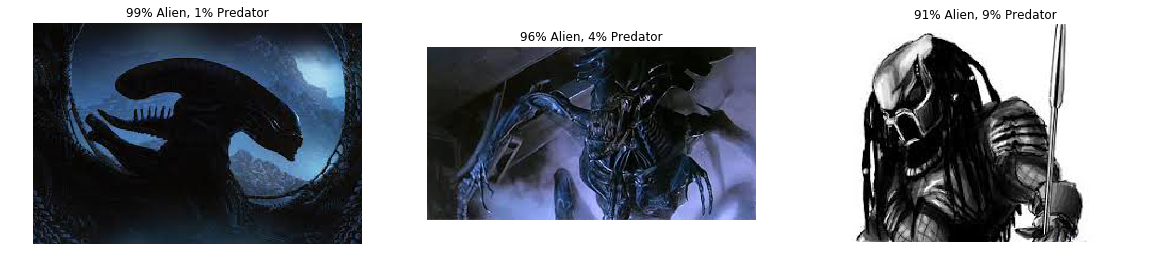

In [12]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)